In [1]:
library(caret)
library(mixOmics)

Loading required package: ggplot2

Loading required package: lattice

Loading required package: MASS


Loaded mixOmics 6.32.0
Thank you for using mixOmics!
Tutorials: http://mixomics.org
Bookdown vignette: https://mixomicsteam.github.io/Bookdown
Questions, issues: Follow the prompts at http://mixomics.org/contact-us
Cite us:  citation('mixOmics')



Attaching package: ‘mixOmics’


The following objects are masked from ‘package:caret’:

    nearZeroVar, plsda, splsda




In [2]:
setwd("..")  # Go one level up to CAD-omics root
my_multiomics <- readRDS("data/processed/stability_multiomics_missing.rds")


In [3]:
# Combine continuous and binary clinical data into one block
Clinical_combined <- cbind(my_multiomics$data$clinical_cont,
                           my_multiomics$data$clinical_binary)

# Create updated data list
data <- list(
  miRNA    = my_multiomics$data$mirna,
  SNP      = my_multiomics$data$snp,
  Clinical = Clinical_combined
)

# Check dimensions
lapply(data, dim)



$miRNA
[1]  67 183

$SNP
[1]  67 189

$Clinical
[1] 67 44

In [4]:
# Response variable (status: lipid-rich plaque yes/no)
Y <- my_multiomics$data$status
summary(Y)

0  1 
35 32

In [11]:
my_multiomics <- readRDS("/home/vik/RSU_work/CAD-omics/data/processed/stability_multiomics_imputed.rds")

# Build blocks
clinical_combined <- cbind(my_multiomics$data$clinical_cont,
                           my_multiomics$data$clinical_binary)

data_blocks <- list(
  miRNA    = my_multiomics$data$mirna,
  SNP      = my_multiomics$data$snp,
  Clinical = clinical_combined
)



# --------------------------
# 2. Clean and match samples
# --------------------------
# Filter out samples with all NA per block
data_blocks <- lapply(data_blocks, function(x) x[complete.cases(x), , drop = FALSE])

# Get intersecting sample names
common_samples <- Reduce(intersect, lapply(data_blocks, rownames))

# Subset data blocks
data_blocks <- lapply(data_blocks, function(x) x[common_samples, , drop = FALSE])

# Prepare sample labels (status)
status <- my_multiomics$data$status
names(status) <- rownames(my_multiomics$data$mirna)
status <- status[common_samples]
status <- droplevels(status)
status_labels <- as.character(status)

# Check dimensions
cat("Sample sizes per block:\n")
print(lapply(data_blocks, dim))
cat("Status table:\n")
print(table(status))




# Outcome labels aligned AFTER filtering
status <- my_multiomics$data$status
names(status) <- rownames(my_multiomics$data$mirna)
status <- status[common_samples]
Y <- droplevels(as.factor(as.character(status)))  # final Y

Sample sizes per block:
$miRNA
[1]  33 183

$SNP
[1]  33 189

$Clinical
[1] 33 44

Status table:
status
 0  1 
21 12 


In [12]:
####################################
### GLOBAL SETTINGS / SMALL UTILS ###
####################################

maxComp  <- 3   # upper bound for selecting number of components
dist_metric <- "centroids.dist"  # more stable than mahalanobis on small N
# keepX grid helper (clipped by block size)
keep_grid <- function(M){
  base <- c(5:9, seq(10, 18, 2), seq(20, 30, 5))
  unique(pmin(base, ncol(M)))
}

# Drop exact zero-variance columns
rm_zerovar <- function(M){
  v <- apply(M, 2, function(x) var(x, na.rm = TRUE))
  keep <- which(!is.na(v) & v > 0)
  if(length(keep) == 0) stop("All columns removed due to zero variance in a block.")
  M[, keep, drop = FALSE]
}


In [16]:
# --- Pairwise sPLS between blocks (use your cleaned 'data_blocks') ---

# helper: cap keepX/keepY by available features
cap_keep <- function(k, p) pmax(1, pmin(k, p))

# choose how many variables per component to select (for 2 comps here)
raw_keep <- c(25, 25)

kx_mirna   <- cap_keep(raw_keep, ncol(data_blocks$miRNA))
ky_snp     <- cap_keep(raw_keep, ncol(data_blocks$SNP))
ky_clin    <- cap_keep(raw_keep, ncol(data_blocks$Clinical))
kx_snp     <- cap_keep(raw_keep, ncol(data_blocks$SNP))
kx_clin    <- cap_keep(raw_keep, ncol(data_blocks$Clinical))

# miRNA vs SNP
pls1 <- mixOmics::spls(
  X = data_blocks$miRNA,
  Y = data_blocks$SNP,
  keepX = kx_mirna,
  keepY = ky_snp
)

# miRNA vs Clinical
pls2 <- mixOmics::spls(
  X = data_blocks$miRNA,
  Y = data_blocks$Clinical,
  keepX = kx_mirna,
  keepY = ky_clin
)

# SNP vs Clinical
pls3 <- mixOmics::spls(
  X = data_blocks$SNP,
  Y = data_blocks$Clinical,
  keepX = kx_snp,
  keepY = ky_clin
)

In [13]:
# ---- PLS Pairwise Models (example with arbitrary keepX values) ----
list.keepX <- c(25, 25) # adjust as needed
list.keepY <- c(25, 25)


In [14]:
# miRNA vs SNP
pls1 <- spls(data[["miRNA"]], data[["SNP"]],
             keepX = list.keepX, keepY = list.keepY)

# miRNA vs Clinical
pls2 <- spls(data[["miRNA"]], data[["Clinical"]],
             keepX = list.keepX, keepY = list.keepY)

# SNP vs Clinical
pls3 <- spls(data[["SNP"]], data[["Clinical"]],
             keepX = list.keepX, keepY = list.keepY)


ERROR: Error in data[["miRNA"]]: object of type 'closure' is not subsettable


In [17]:
table(pls1$names$block)



X Y 
1 1 

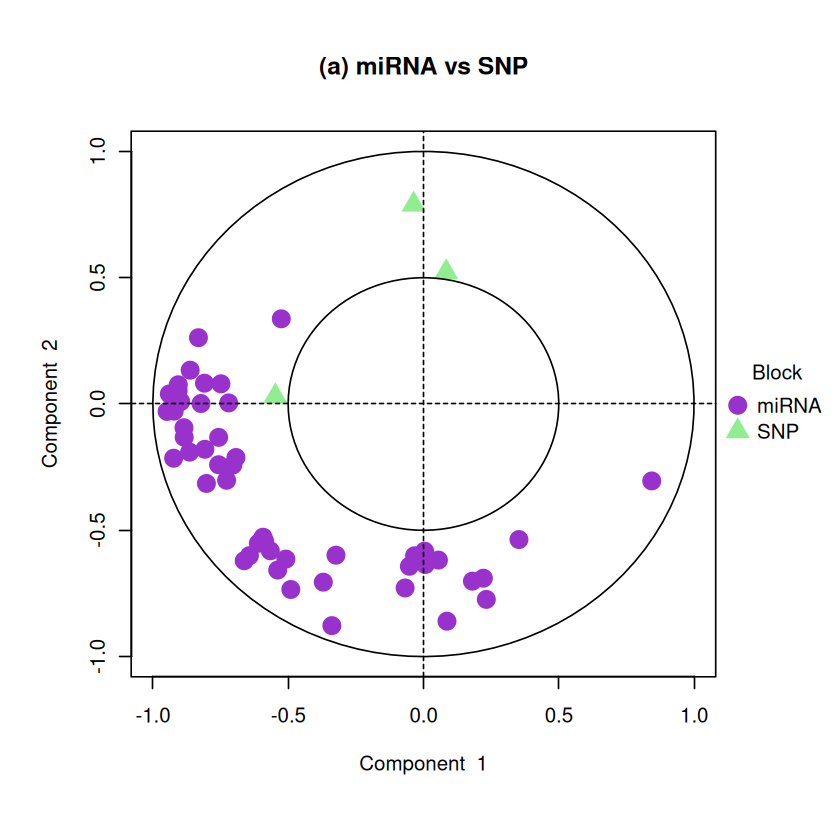

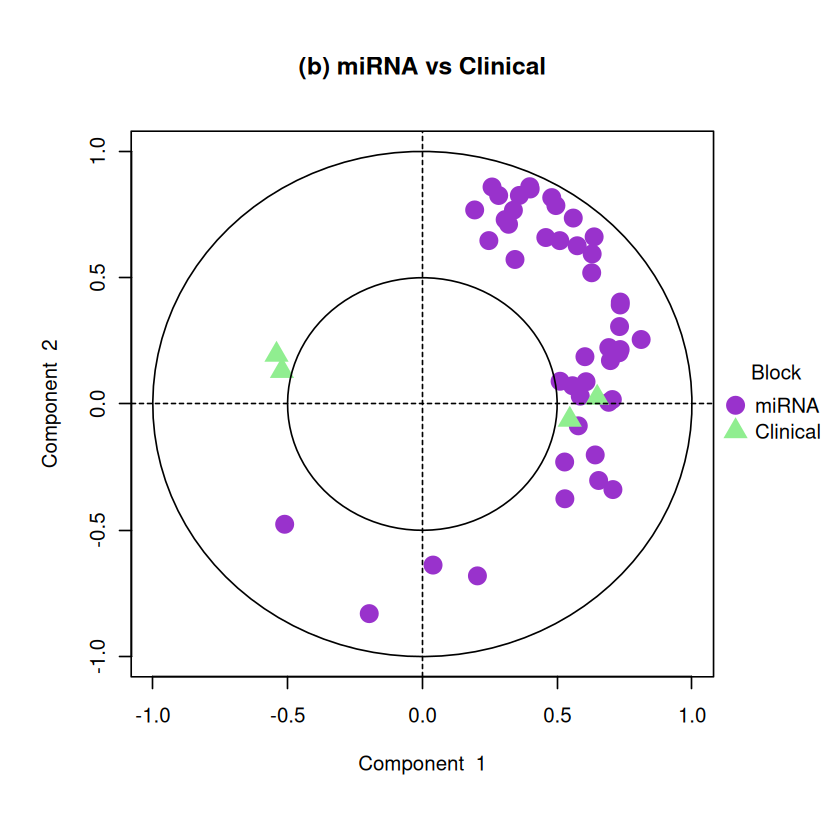

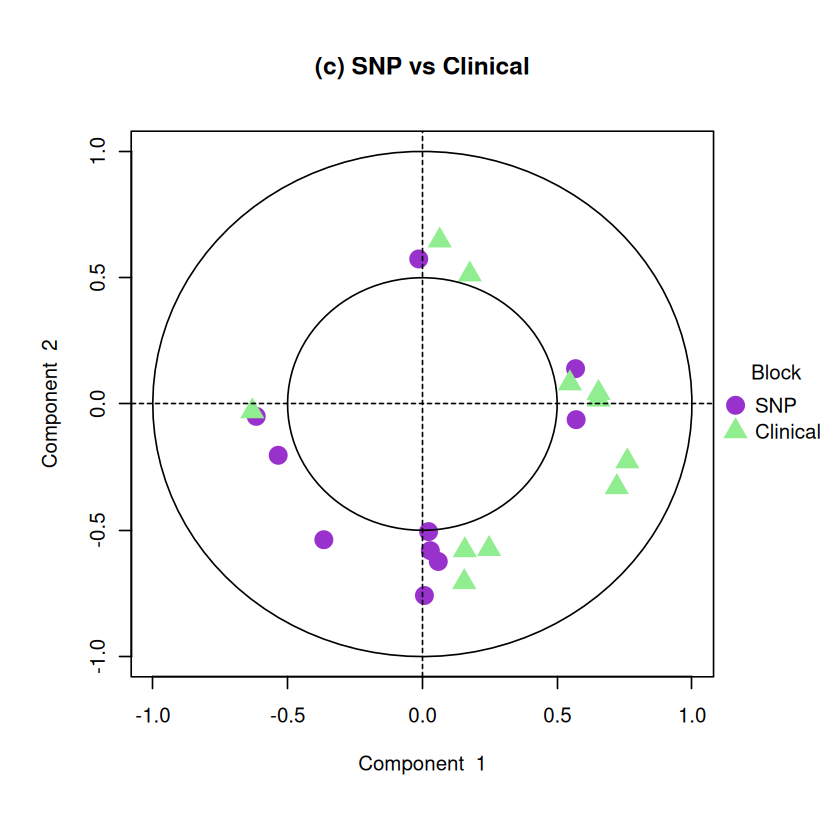

In [18]:
# ---- Plots ----
plotVar(pls1, cutoff = 0.5, title = "(a) miRNA vs SNP",
        legend = c("miRNA", "SNP"),
        var.names = FALSE, style = 'graphics',
        pch = c(16, 17), cex = c(2,2),
        col = c('darkorchid', 'lightgreen'))

plotVar(pls2, cutoff = 0.5, title = "(b) miRNA vs Clinical",
        legend = c("miRNA", "Clinical"),
        var.names = FALSE, style = 'graphics',
        pch = c(16, 17), cex = c(2,2),
        col = c('darkorchid', 'lightgreen'))

plotVar(pls3, cutoff = 0.5, title = "(c) SNP vs Clinical",
        legend = c("SNP", "Clinical"),
        var.names = FALSE, style = 'graphics',
        pch = c(16, 17), cex = c(2,2),
        col = c('darkorchid', 'lightgreen'))


In [19]:
# ---- Correlation calculations ----
cor(pls1$variates$X, pls1$variates$Y)  # miRNA vs SNP
cor(pls2$variates$X, pls2$variates$Y)  # miRNA vs Clinical
cor(pls3$variates$X, pls3$variates$Y)  # SNP vs Clinical


,comp1,comp2
comp1,0.8714937,2.190094e-17
comp2,-0.1896643,9.325887e-01


,comp1,comp2
comp1,0.7895945,-3.285278e-17
comp2,-0.2093665,7.120263e-01


,comp1,comp2
comp1,0.8867962,-9.989772e-18
comp2,-0.1467509,9.015213e-01


In [20]:
# --- Create DIABLO design matrix ---
design <- matrix(0.1,
                 ncol = length(data),
                 nrow = length(data),
                 dimnames = list(names(data), names(data)))
diag(design) <- 0  # set diagonal to 0
design


0


In [21]:
# Force internal near-zero-var removal at model creation
basic.diablo.model <- block.splsda(
  X = data,
  Y = Y,
  ncomp = 5,
  design = design,
  near.zero.var = TRUE   
)


ERROR: Error in X[[1]]: object of type 'closure' is not subsettable


In [22]:
# 1) sanity checks
stopifnot(is.list(data_blocks), length(data_blocks) >= 2)
stopifnot(all(sapply(data_blocks, is.matrix)))
rn <- lapply(data_blocks, rownames)
stopifnot(length(Reduce(intersect, rn)) == nrow(data_blocks[[1]]))
stopifnot(all(rownames(data_blocks[[1]]) == names(Y)))

# 2) build DIABLO design (lightly connected blocks)
design <- matrix(0.1,
                 nrow = length(data_blocks),
                 ncol = length(data_blocks),
                 dimnames = list(names(data_blocks), names(data_blocks)))
diag(design) <- 0

# 3) fit model (use your blocks object, NOT 'data')
basic.diablo.model <- mixOmics::block.splsda(
  X = data_blocks,
  Y = Y,
  ncomp = 5,
  design = design,
  near.zero.var = TRUE
)

Design matrix has changed to include Y; each block will be
            linked to Y.



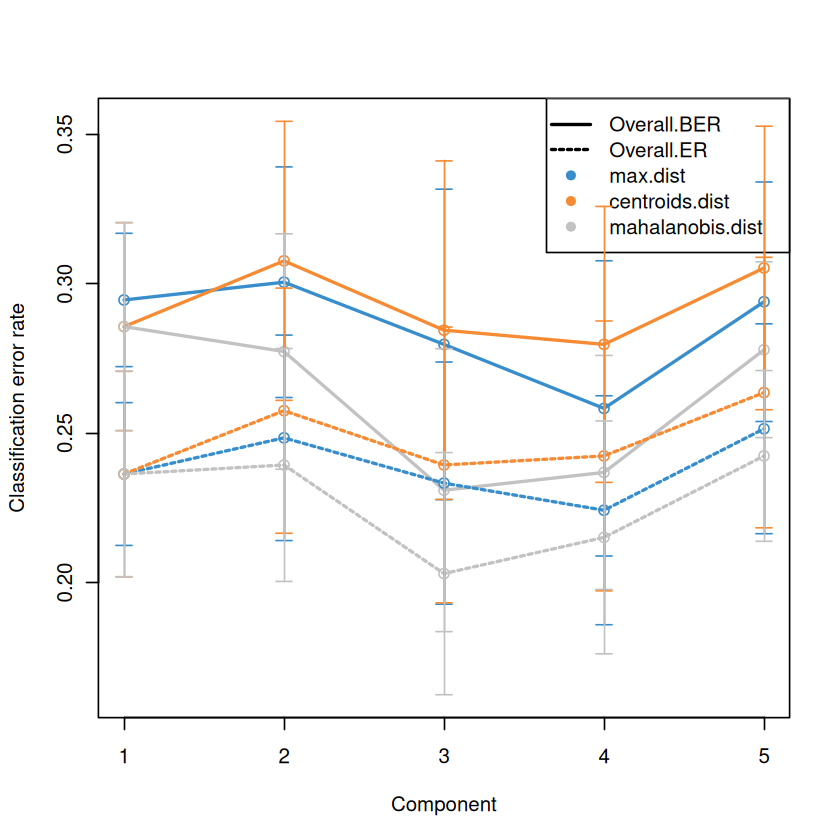

In [23]:
perf.diablo <- perf(basic.diablo.model,
                    validation = 'Mfold',
                    folds = 10,
                    nrepeat = 10,
                    near.zero.var = TRUE)


plot(perf.diablo)  # visualize error rates per ncomp

In [24]:
# Optimal number of components
ncomp <- perf.diablo$choice.ncomp$WeightedVote["Overall.BER", "centroids.dist"]
perf.diablo$choice.ncomp$WeightedVote
ncomp

,max.dist,centroids.dist,mahalanobis.dist
Overall.ER,1,1,1
Overall.BER,1,1,3


[1] 1

In [25]:
# --- Tune keepX for each block ---
# Example grid (adjust feature ranges as needed for your data)
test.keepX <- list(
  mirna    = c(5:9, seq(10, 20, 2), seq(25, 50, 5)),
  snp      = c(5:9, seq(10, 20, 2), seq(25, 40, 5)),
  clinical = c(5:9, seq(10, 20, 2))
)

t1 <- proc.time()

In [26]:
library(BiocParallel)

In [27]:
tune.model <- tune.block.splsda(X = data, Y = Y,
                                #ncomp = ncomp,
                                ncomp = 2,
                                test.keepX = test.keepX,
                                design = design,
                                validation = 'Mfold', folds = 10,
                                nrepeat = 1,
                                dist = "centroids.dist")

ERROR: Error in X[[1]]: object of type 'closure' is not subsettable


In [17]:
t2 <- proc.time()
running_time <- t2 - t1
running_time

     user    system   elapsed 
 2834.927 15976.293   845.729 

In [18]:
list.keepX <- tune.model$choice.keepX
list.keepX

$miRNA
[1] 6 5

$SNP
[1] 6 5

$Clinical
[1] 5 7

In [19]:
# --- Final DIABLO model ---
final.diablo.model <- block.splsda(
  X       = data,
  Y       = Y,
  ncomp   = 2,
  #ncomp   = ncomp,         # from perf() or forced
  keepX   = list.keepX,    # from tune.block.splsda()
  design  = design
)

Design matrix has changed to include Y; each block will be
            linked to Y.



In [20]:
# Inspect design (Y is auto-included)
final.diablo.model$design


,miRNA,SNP,Clinical,Y
miRNA,0.0,0.1,0.1,1
SNP,0.1,0.0,0.1,1
Clinical,0.1,0.1,0.0,1
Y,1.0,1.0,1.0,0


In [21]:
# Example: selected variables from SNP block on component 1
selectVar(final.diablo.model, block = 'SNP', comp = 1)$SNP$name

# Example: selected variables from miRNA block on component 1
selectVar(final.diablo.model, block = 'miRNA', comp = 1)$miRNA$name

# Example: selected variables from Clinical block on component 1
selectVar(final.diablo.model, block = 'Clinical', comp = 1)$Clinical$name

[1] "rs1510758"  "rs17680741" "rs582384"   "rs10857147" "rs7413494" 
[6] "rs3796587"

[1] "hsa-miR-191-5p" "hsa-miR-183-5p" "hsa-miR-10a-5p" "hsa-miR-501-3p"
[5] "hsa-let-7b-5p"  "hsa-miR-142-5p"

[1] "Target_necrotic"            "Target_fibrotic"           
[3] "Plaque_necrolipidic_tissue" "Target_lipidic"            
[5] "NE_abs"

In [22]:
# Example: selected variables from SNP block on component 1
selectVar(final.diablo.model, block = 'SNP', comp = 2)$SNP$name

# Example: selected variables from miRNA block on component 1
selectVar(final.diablo.model, block = 'miRNA', comp = 2)$miRNA$name

# Example: selected variables from Clinical block on component 1
selectVar(final.diablo.model, block = 'Clinical', comp = 2)$Clinical$name

[1] "rs7177201"  "rs56408342" "rs1177562"  "rs633185"   "rs6026739"

[1] "hsa-miR-432-5p" "hsa-miR-339-3p" "hsa-miR-223-5p" "hsa-miR-23a-3p"
[5] "hsa-miR-423-3p"

[1] "Height" "Sex"    "Weight" "Age"    "MO_abs" "HDL"    "HCT"

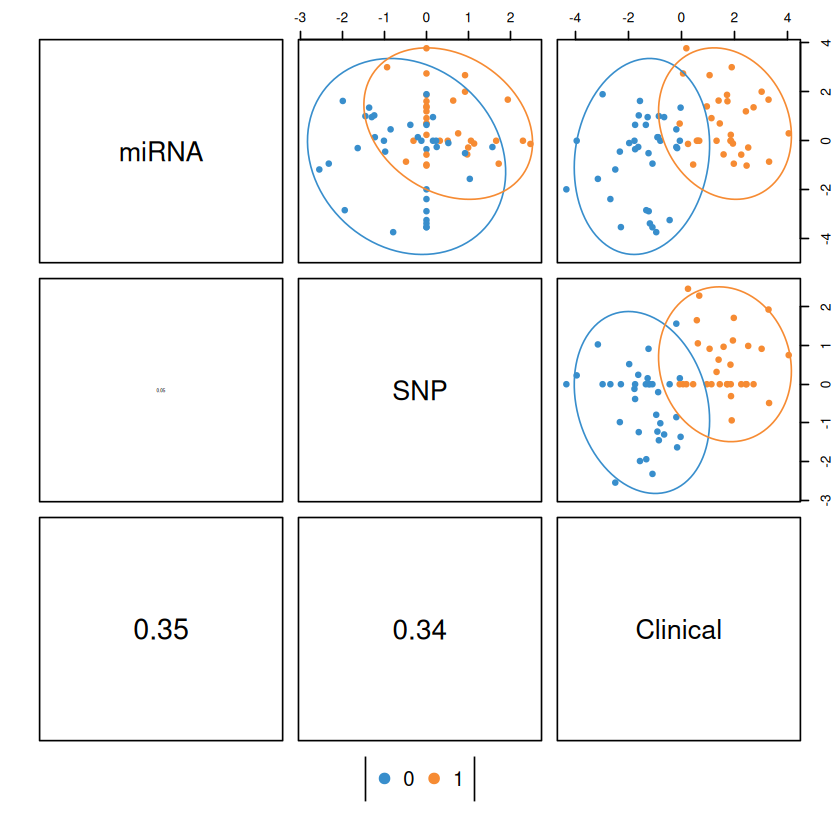

In [23]:
plotDiablo(final.diablo.model, ncomp = )

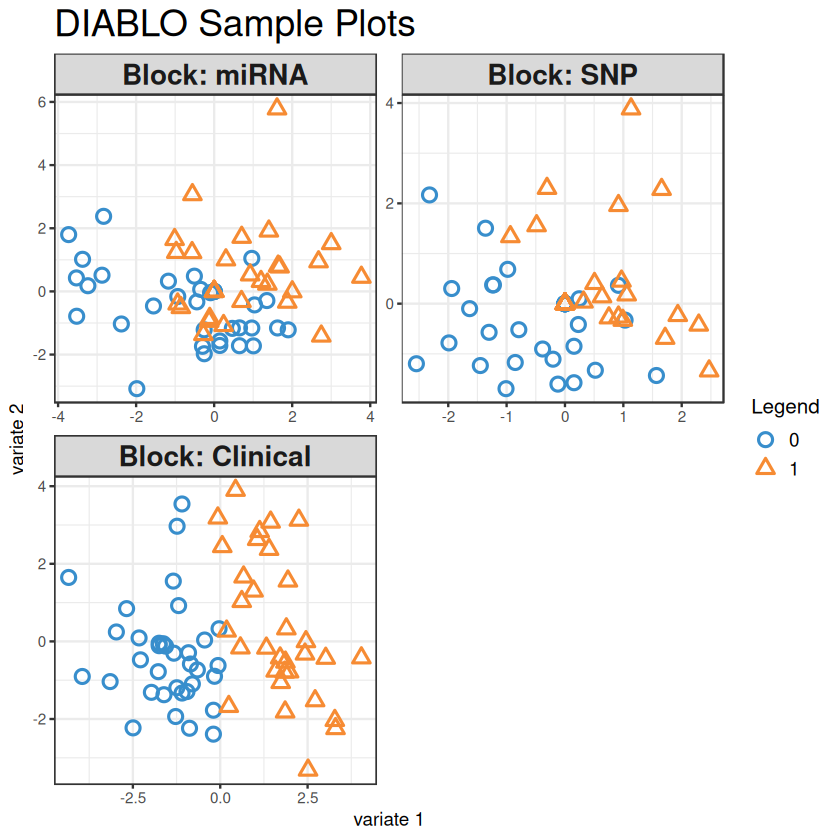

In [24]:
plotIndiv(final.diablo.model, ind.names = FALSE, legend = TRUE,
          title = 'DIABLO Sample Plots')

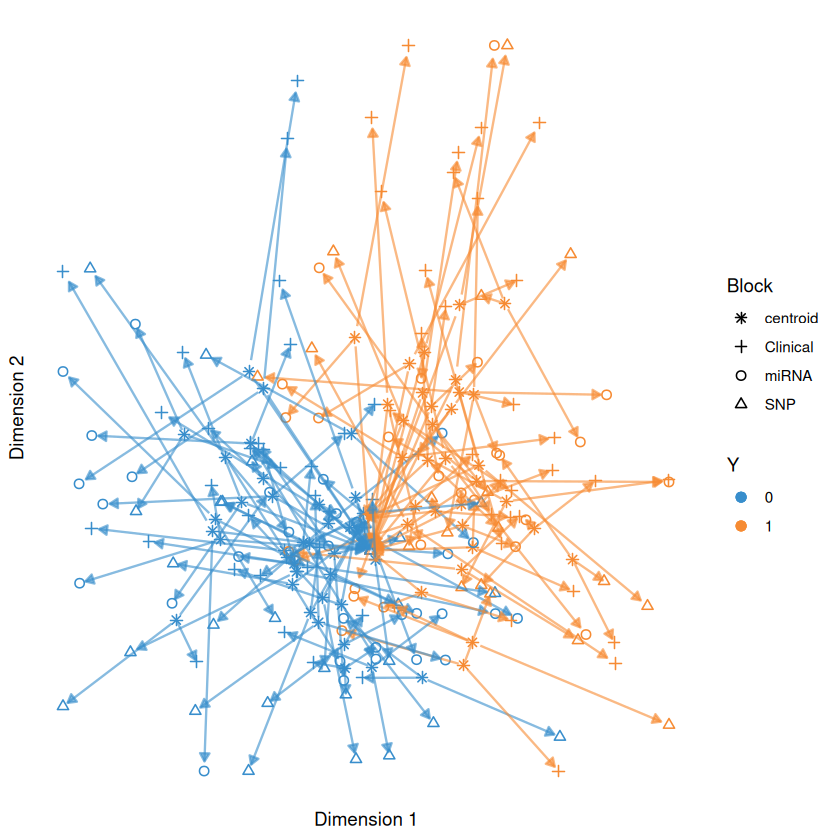

In [25]:
plotArrow(final.diablo.model, ind.names = FALSE, legend = TRUE,
          title = 'DIABLO')

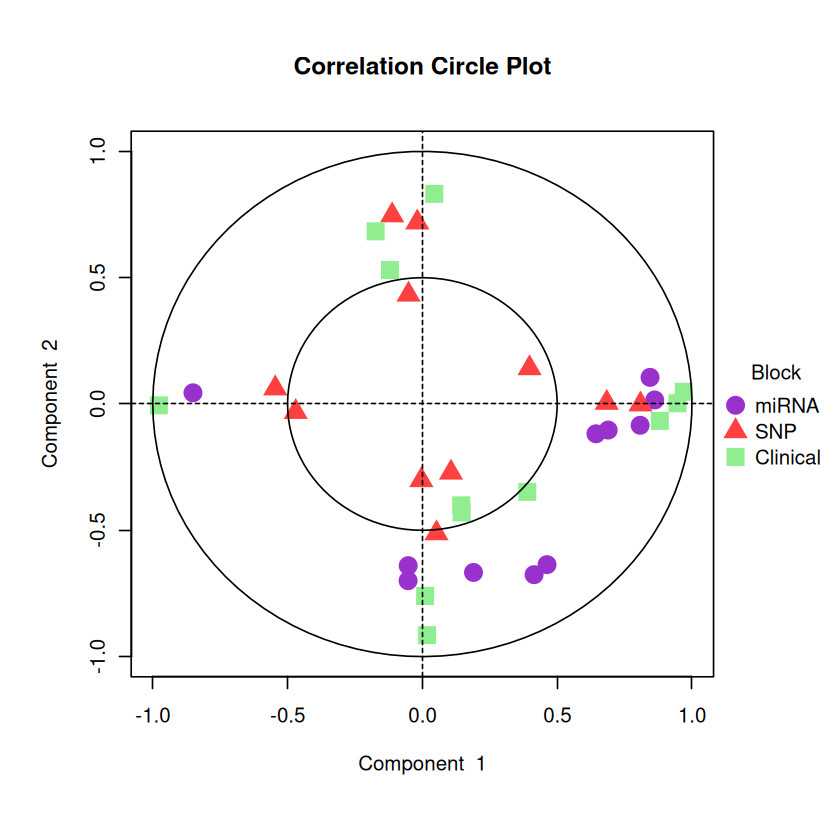

In [26]:
plotVar(final.diablo.model, var.names = FALSE, style = 'graphics', legend = TRUE,
        pch = c(16, 17, 15), cex = c(2,2,2),
        col = c('darkorchid', 'brown1', 'lightgreen'))

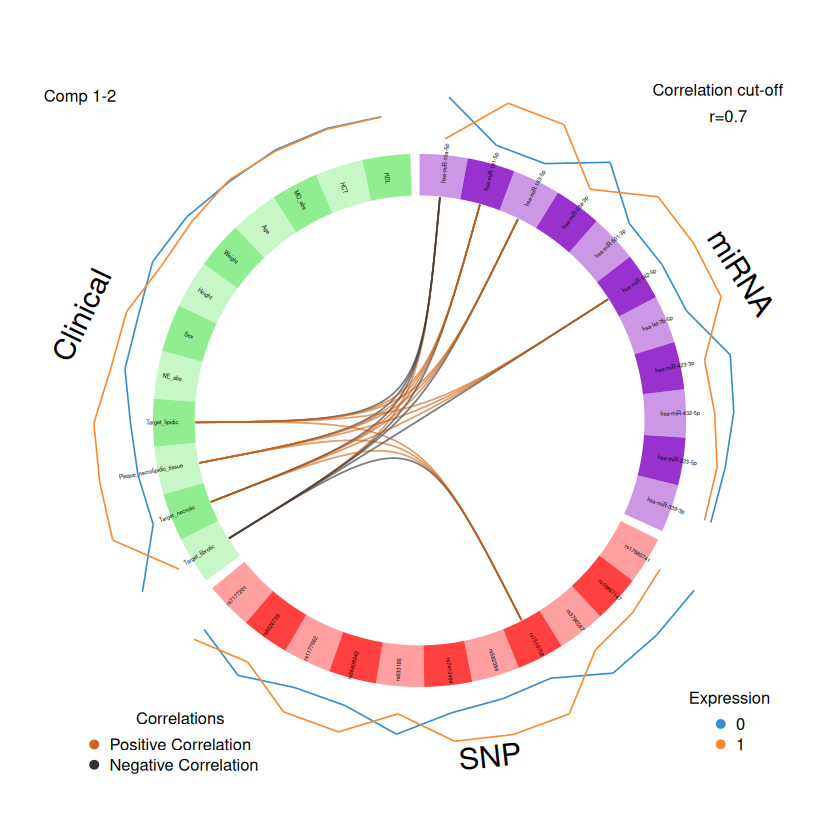

In [27]:
circosPlot(final.diablo.model, cutoff = 0.7, line = TRUE,
           color.blocks = c('darkorchid', 'brown1', 'lightgreen'),
           color.cor = c("chocolate3","grey20"), size.labels = 1.5)


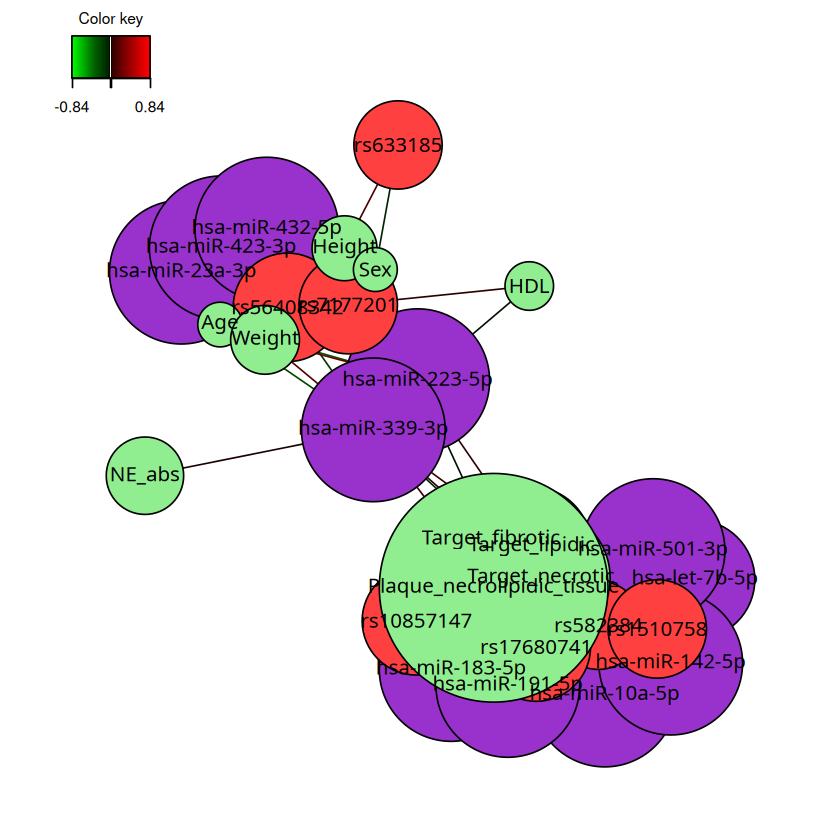

In [28]:
network(final.diablo.model, blocks = c(1,2,3),
        color.node = c('darkorchid', 'brown1', 'lightgreen'), cutoff = 0.4)

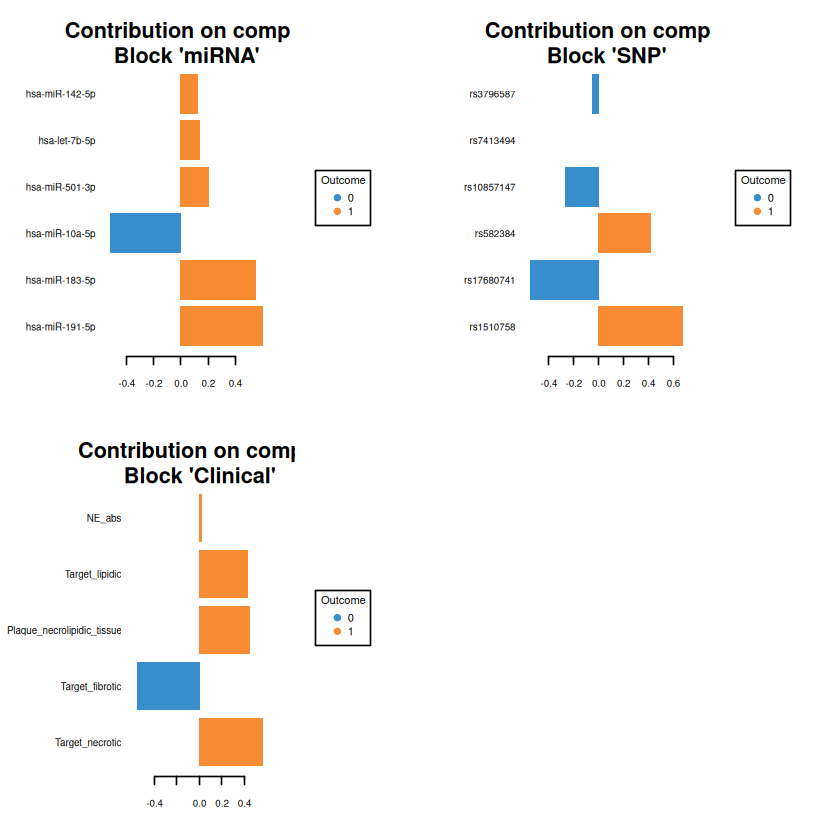

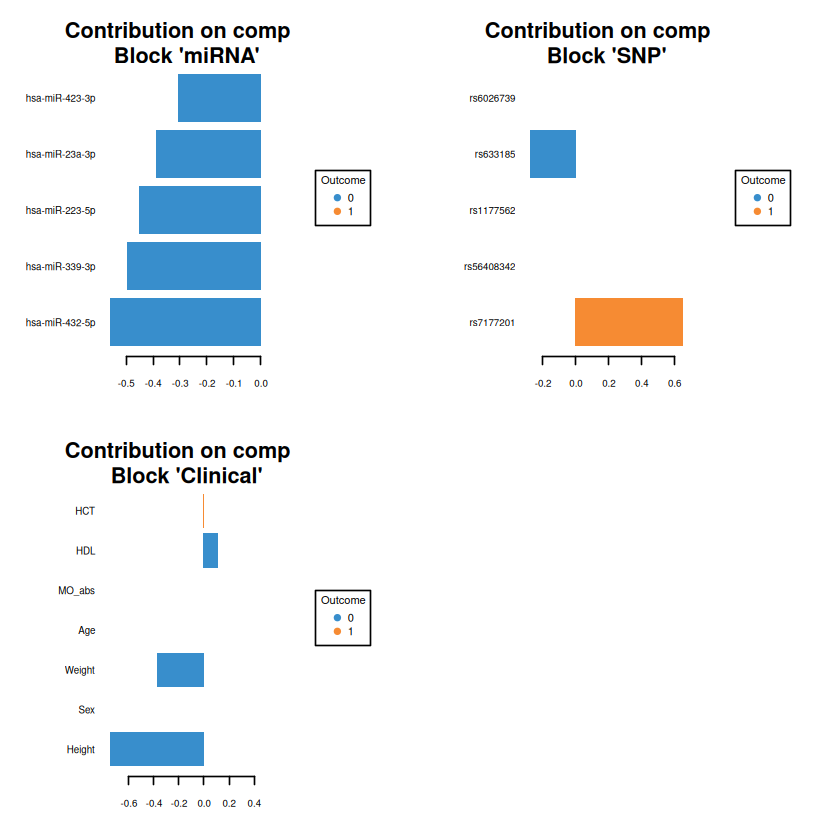

In [29]:
plotLoadings(final.diablo.model, comp = 1, contrib = 'max', method = 'median')
plotLoadings(final.diablo.model, comp = 2, contrib = 'max', method = 'median')


trimming values to [-3, 3] range for cim visualisation. See 'trim' arg in ?cimDiablo


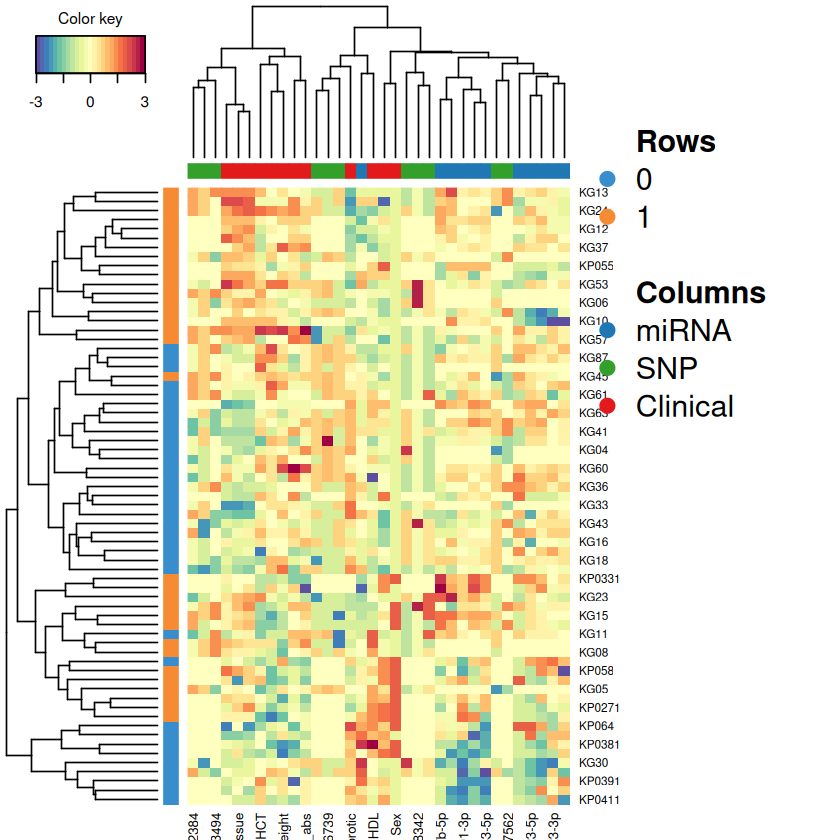

In [30]:
cimDiablo(final.diablo.model)

In [31]:
perf.diablo <- perf(
  final.diablo.model,
  validation = 'Mfold',
  M = 10,
  nrepeat = 10,
  dist = 'centroids.dist'
)

perf.diablo$MajorityVote.error.rate
perf.diablo$WeightedVote.error.rate


,comp1,comp2
0,0.1542857,0.2200000
1,0.3937500,0.4562500
Overall.ER,0.2686567,0.3328358
Overall.BER,0.2740179,0.3381250


,comp1,comp2
0,0.1542857,0.2200000
1,0.3937500,0.4562500
Overall.ER,0.2686567,0.3328358
Overall.BER,0.2740179,0.3381250


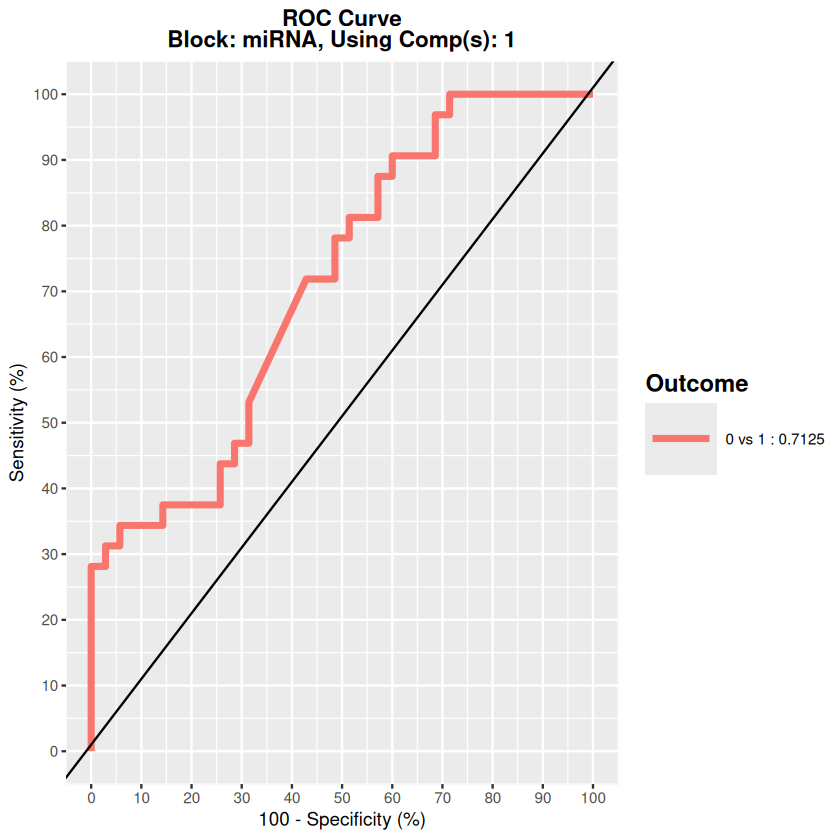

In [32]:
auc.splsda <- auroc(
  final.diablo.model,
  roc.block = "miRNA",
  roc.comp = 1,    # or 2 if ncomp > 1
  print = FALSE
)


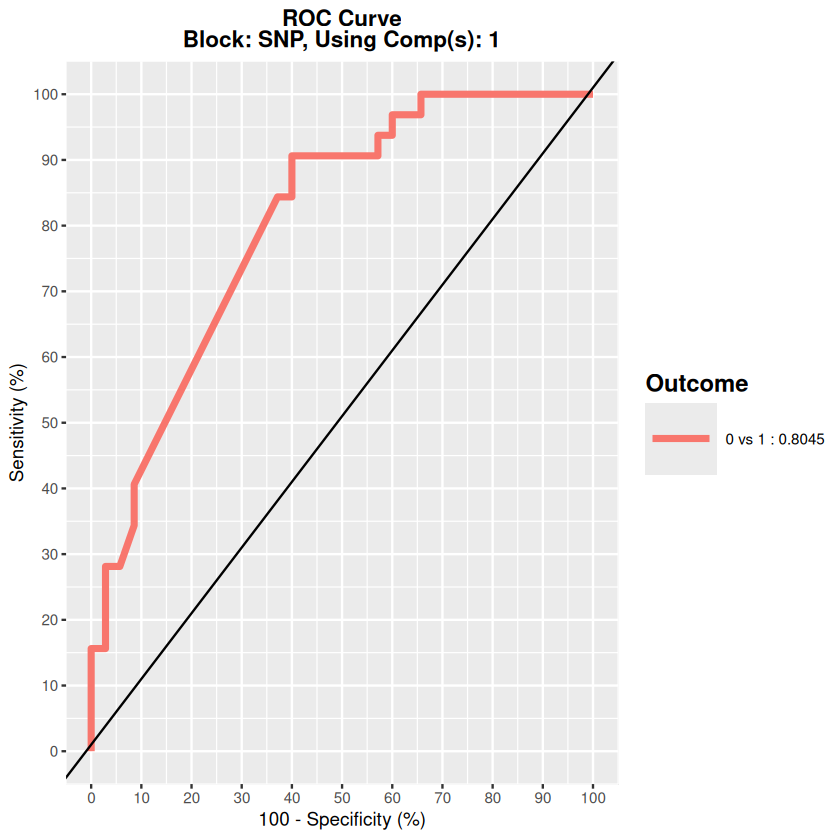

In [33]:
auc.splsda <- auroc(
  final.diablo.model,
  roc.block = "SNP",
  roc.comp = 1,    # or 2 if ncomp > 1
  print = FALSE
)


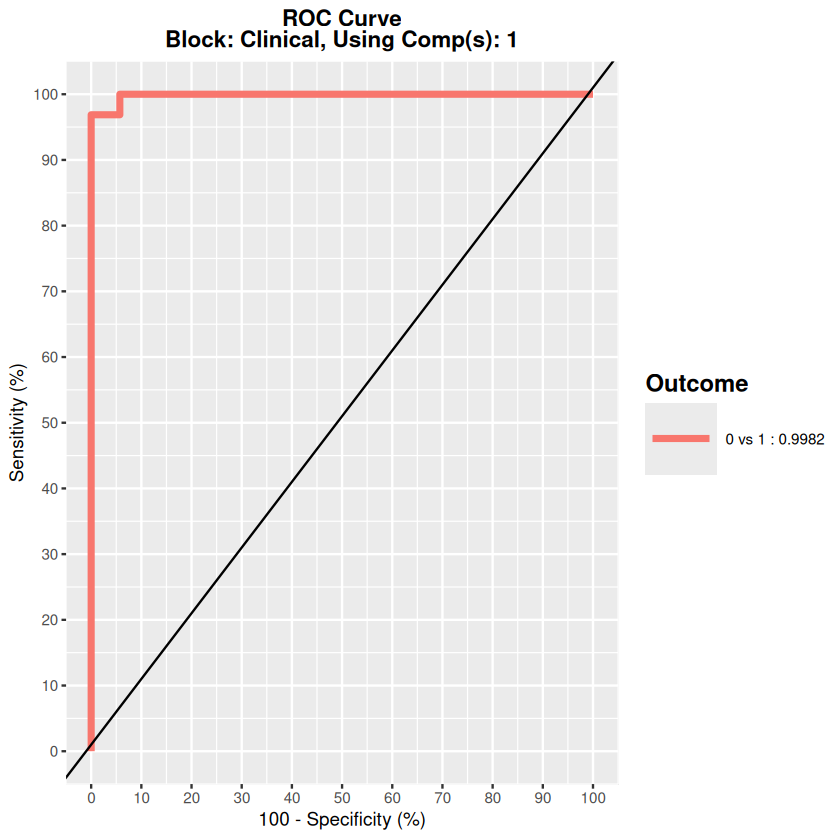

In [34]:
auc.splsda <- auroc(
  final.diablo.model,
  roc.block = "Clinical",
  roc.comp = 1,    # or 2 if ncomp > 1
  print = FALSE
)
